# Relax Challenge

The data has two tables:

* A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years.
* A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Load and examine the user info
users = pd.read_csv('takehome_users.csv', encoding ="ISO-8859-1")
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
#Convert the time columns to datetime
users.creation_time = pd.to_datetime(users.creation_time)
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')

#Convert the columns to boolean
users.opted_in_to_mailing_list = users.opted_in_to_mailing_list.astype('bool')
users.enabled_for_marketing_drip = users.enabled_for_marketing_drip.astype('bool')

#Rename correct object_id to user_id
users.rename(columns={'object_id' : "user_id"}, inplace=True)


In [6]:
#Parse out what server the user accesses email on and make a categorical
def strip_email(email):
    return email.split('@')[1]
    
users.email = users.email.apply(strip_email).astype('category')

In [7]:
# Convert to categorical data
users.creation_source = users.creation_source.astype('category')

# Keep only info on if user was invited; not by who
users['invited'] = np.where(users['invited_by_user_id'].isnull(), True, False)
users.drop('invited_by_user_id', axis=1, inplace=True)

#We don't need personal information
users.drop(['name'], axis=1, inplace=True)

In [8]:
engagement = pd.read_csv('takehome_user_engagement.csv', encoding ="ISO-8859-1")
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [21]:
# Load and examine the engagement logs
engagement.describe()

,user_id
count,207917.000000
mean,5913.314197
std,3394.941674
min,1.000000
25%,3087.000000
50%,5682.000000
75%,8944.000000
max,12000.000000


In [9]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [10]:
engagement.visited.unique()

array([1])

In [11]:
#Convert time column to datetime
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

#Drop visited column, its always 1
engagement.drop('visited', axis=1, inplace=True)

In [12]:
adopted_users = pd.DataFrame(columns=['user_id', 'adopted'])

for group in engagement.groupby('user_id'):
    
    #Define useful vars
    user_id = group[0]
    user_times = group[1]['time_stamp'].sort_values().reset_index(drop=True)
    num_engage = len(user_times)
    
    #If there are less than 3 engagements, they do not qualify
    if num_engage < 3:
        continue
     
    #Iterate over the engagement timestampe
    for i, stamp in enumerate(user_times):
        
        #Ensure we don't go off the end of the array of timestamps
        if i == num_engage-2:
            break
            
        #Define useful timestamp vars    
        start = stamp
        end = start + pd.Timedelta('7D')
        next1 = user_times[i+1]
        next2 = user_times[i+2]
        
        #Are the next two timestamps within a week?
        if (next1 < end) & (next2 < end):
            adopted_users = adopted_users.append(pd.DataFrame([[user_id, True]], columns=['user_id', 'adopted']),ignore_index=True)
            break    
            
print("Number of adopted users: " + str(len(adopted_users)))

Number of adopted users: 1602


In [13]:
#Merge the adopted user info to users dataframe
users = pd.merge(users, adopted_users, on='user_id', how='outer')

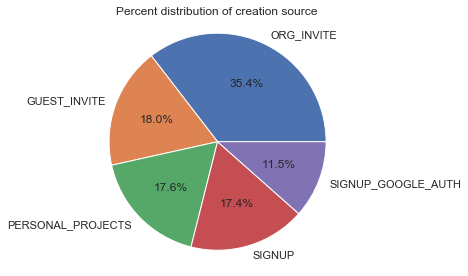

In [14]:
import matplotlib.pyplot as plt
sns.set(color_codes=True)

# create dataframe for creation source
df_source = users.creation_source.value_counts()
df_source = df_source.reset_index()

# Put parameter values
plt.pie(
    df_source['creation_source'],
    labels=df_source['index'],
    shadow=False,
    startangle=0,
    autopct='%1.1f%%',
    )

# Add title
plt.title('Percent distribution of creation source')
plt.axis('equal')

# Display plot
plt.tight_layout()
plt.show()

In [15]:
users.email.unique()

[yahoo.com, gustr.com, jourrapide.com, hotmail.com, cuvox.de, ..., owujh.com, cgbld.com, uyhoy.com, eaouk.com, iuxiw.com]
Length: 1184
Categories (1184, object): [yahoo.com, gustr.com, jourrapide.com, hotmail.com, ..., cgbld.com, uyhoy.com, eaouk.com, iuxiw.com]

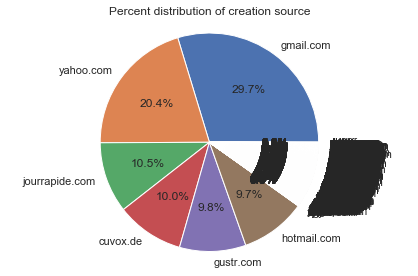

In [16]:
import matplotlib.pyplot as plt
sns.set(color_codes=True)

# create dataframe for creation source
df_source = users.email.value_counts()
df_source = df_source.reset_index()

# Put parameter values
plt.pie(
    df_source['email'],
    labels=df_source['index'],
    shadow=False,
    startangle=0,
    autopct='%1.1f%%',
    )

# Add title
plt.title('Percent distribution of creation source')
plt.axis('equal')

# Display plot
plt.tight_layout()
plt.show()

In [17]:
#Re-code datetime columns
users['creation_year'] = users.creation_time.dt.year
users['creation_month'] = users.creation_time.dt.month
users['creation_day'] = users.creation_time.dt.day
users['last_session_year'] = users.last_session_creation_time.dt.year
users['last_session_month'] = users.last_session_creation_time.dt.month
users['last_session_day'] = users.last_session_creation_time.dt.day

#Drop unnecessary columns
users.drop(['creation_time', 'last_session_creation_time', 'user_id', 'email'], axis=1, inplace=True)

In [18]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
creation_source               12000 non-null category
opted_in_to_mailing_list      12000 non-null bool
enabled_for_marketing_drip    12000 non-null bool
org_id                        12000 non-null int64
invited                       12000 non-null bool
adopted                       1602 non-null object
creation_year                 12000 non-null int64
creation_month                12000 non-null int64
creation_day                  12000 non-null int64
last_session_year             8823 non-null float64
last_session_month            8823 non-null float64
last_session_day              8823 non-null float64
dtypes: bool(3), category(1), float64(3), int64(4), object(1)
memory usage: 890.8+ KB


In [19]:
#Fill null values with 0 to represent no log in
users.last_session_year.fillna(0, inplace=True)
users.last_session_month.fillna(0, inplace=True)
users.last_session_day.fillna(0, inplace=True)
users.adopted.fillna(False, inplace=True)

In [22]:
#Convert the data
users= pd.get_dummies(users, columns=['creation_source'])

In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#construct the dataset X, y

X = pd.DataFrame(scaler.fit_transform(users.drop('adopted', axis=1)))
y = users.adopted

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X.values, y.values, test_size=0.20, random_state=5)

clf = LogisticRegression(solver='lbfgs')
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print("Accuracy score: ", accuracy_score(clf.predict(Xtestlr), ytestlr))


print("Regression coefficients: ", clf.coef_)
print("Intecept: ", clf.intercept_) 
print("Column names: ", (users.drop('adopted', axis=1).columns.values))

Accuracy score:  0.8691666666666666
Regression coefficients:  [[ 0.03291431 -0.04215655  0.170275   -0.03192175 -0.39199594  0.34212131
   0.03410883  3.53697502 -0.76474239 -0.27261274  0.09563608 -0.04356496
   0.05664408 -0.0788127  -0.02383694]]
Intecept:  [-3.27216605]
Column names:  ['opted_in_to_mailing_list' 'enabled_for_marketing_drip' 'org_id'
 'invited' 'creation_year' 'creation_month' 'creation_day'
 'last_session_year' 'last_session_month' 'last_session_day'
 'creation_source_GUEST_INVITE' 'creation_source_ORG_INVITE'
 'creation_source_PERSONAL_PROJECTS' 'creation_source_SIGNUP'
 'creation_source_SIGNUP_GOOGLE_AUTH']


/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [61]:
feature_importance = pd.DataFrame(clf.coef_, columns=(users.drop('adopted', axis=1).columns.values)).transpose()
feature_importance.rename(columns={0: 'correlation'}, inplace=True)

In [62]:
feature_importance.nlargest(3, columns=['correlation'])

,correlation
last_session_year,3.536975
creation_month,0.342121
org_id,0.170275


In [63]:
feature_importance.nsmallest(3, columns=['correlation'])

,correlation
last_session_month,-0.764742
creation_year,-0.391996
last_session_day,-0.272613


In [64]:
feature_importance.sort_values(by=['correlation'], ascending=False)

,correlation
last_session_year,3.536975
creation_month,0.342121
org_id,0.170275
creation_source_GUEST_INVITE,0.095636
creation_source_PERSONAL_PROJECTS,0.056644
creation_day,0.034109
opted_in_to_mailing_list,0.032914
creation_source_SIGNUP_GOOGLE_AUTH,-0.023837
invited,-0.031922
enabled_for_marketing_drip,-0.042157


The feature rankings in the table above shows what features can predict the adopted users best based on the correlation coefficients. Those are last_session_month, last_session_day, last_session_year, creation_month, creation_year and org_id. This boils to three features found in the data: the creation_time, last_session_creation_time and the org_id are the most important factors which can predict user adoption, according to the given defintion.